In [263]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import csv


In [264]:
def load_image(image_path):
    im_rgb = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2GRAY)
    return im_rgb, im_gray

def apply_thresholding(im_gray, threshold):
    _, binary = cv2.threshold(im_gray, threshold, 255, cv2.THRESH_BINARY)
    return binary

def detect_and_draw_lines(sobel_image, original_image, orientation="vertical"):
    # Apply binary threshold to prepare the Sobel image for Hough Transform
    # _, binary = cv2.threshold(sobel_image, 30, 255, cv2.THRESH_BINARY)

    # Perform Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(
        sobel_image,                    # Binary image (edge map)
        rho=1,                     # Distance resolution in pixels
        theta=np.pi/180,           # Angle resolution in radians
        threshold=25,             # Minimum number of intersecting points to detect a line
        minLineLength=10,          # Minimum length of line to be detected
        maxLineGap=10              # Maximum allowed gap between line segments
    )

    # Draw the detected lines on a copy of the original image
    result_image = original_image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if orientation == "vertical":
                # Draw only vertical lines (i.e., where x-coordinates are approximately the same)
                if abs(x1 - x2) < 10:  # Allowable tolerance for a "vertical" line
                    cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            elif orientation == "horizontal":
                # Draw only horizontal lines (i.e., where y-coordinates are approximately the same)
                if abs(y1 - y2) < 10:  # Allowable tolerance for a "horizontal" line
                    cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return result_image, lines

def plot_processing_log(processing_log):
    for i, (title, image) in enumerate(processing_log):
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

def process_image(im_path):
    # --- Load your image ---
    im_rgb, im_gray = load_image(im_path)
    processing_log = [('Original Image', im_rgb)]

    # --- Vertical Edge Detection (Sobel dx=1, dy=0) ---
    sobel_x = cv2.Sobel(im_gray, cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobel_x = cv2.convertScaleAbs(sobel_x)
    processing_log.append(('Vertical Edge Enhancement (Sobel)', sobel_x))

    # --- Horizontal Edge Detection (Sobel dx=0, dy=1) ---
    sobel_y = cv2.Sobel(im_gray, cv2.CV_64F, dx=0, dy=1, ksize=3)
    sobel_y = cv2.convertScaleAbs(sobel_y)
    processing_log.append(('Horizontal Edge Enhancement (Sobel)', sobel_y))

    top_border, bottom_border, white_keys = detect_keys(sobel_x, sobel_y, processing_log, im_rgb)
    return top_border, bottom_border, white_keys, processing_log

def detect_keys(vertical_img, horizontal_img, processing_log, im_rgb):
    # _, vertical_bin = cv2.threshold(vertical_img, 170, 255, cv2.THRESH_BINARY)
    # _, horizontal_bin = cv2.threshold(horizontal_img, 170, 255, cv2.THRESH_BINARY)
    # plt.imshow(vertical_bin, cmap='gray')
    # plt.show()
    # plt.imshow(horizontal_bin, cmap='gray')
    # plt.show()
    row_sum_vertical = np.sum(vertical_img, axis=1)
    
    row_sum_horizontal = np.sum(horizontal_img, axis=1)
    column_sum_horizontal = np.sum(horizontal_img, axis=0)

    a = gaussian_filter1d(row_sum_horizontal, sigma=15)
    peaks, _ = find_peaks(a, height=1000, distance=5)
    plt.plot(a)
    plt.plot(peaks, a[peaks], "x")
    plt.show()
    top_row = peaks[0]
    bottom_row = peaks[-1]
    bottom_of_black_keys = peaks[-2]
    print(top_row, bottom_row)
    
    column_sum_vertical = np.sum(vertical_img[bottom_of_black_keys:bottom_row, :], axis=0)

    # 3. Detect vertical boundaries (for white keys)
    #    by summing the binary image across rows.
    # --------------------------------------------------
    # Sum each column -> large values = a vertical edge
    column_profile_smooth = gaussian_filter1d(column_sum_vertical, sigma=1)

    peaks, properties = find_peaks(column_profile_smooth, height=0, distance=20)
    peak_heights = properties['peak_heights']
    sorted_indices = np.argsort(peak_heights)[::-1]
    top_peaks = peaks[sorted_indices[:53]]
    top_peaks = np.sort(top_peaks)
    white_locations = top_peaks.copy()
    plt.plot(column_profile_smooth)
    plt.plot(top_peaks, column_profile_smooth[top_peaks], "x")
    plt.show()
    # Draw red dots at the detected peaks (x positions) on the original image
    for peak in top_peaks:
        cv2.circle(im_rgb, (peak, im_rgb.shape[0] // 2), 5, (255, 0, 0), -1)

    # Add the modified image with red dots to the processing log
    processing_log.append(('Detected Peaks', im_rgb))
    
    # Plot the image with red dots
    # plt.imshow(im_rgb)
    # plt.title('Detected Peaks')
    # plt.axis('off')
    # plt.show()

    # # 4. Detect black keys. 
    # # sum the row of y = bottom_of_black_keys, and find the peaks
    # # --------------------------------------------------
    # row_sum_at_black_keys =np.sum(horizontal_bin[bottom_of_black_keys-5:bottom_of_black_keys+5, :], axis=0)
    # plt.plot(row_sum_at_black_keys)
    # plt.show()
    row_sum_horizontal = np.sum(horizontal_img, axis=1)

    # a = gaussian_filter1d(row_sum_horizontal, sigma=1)
    peaks, _ = find_peaks(row_sum_horizontal, height=1000, distance=5)
    plt.plot(a)
    plt.title("Horizontal Bordes")
    plt.plot(peaks, a[peaks], "x")
    plt.show()

    top_border = peaks[0]
    white_keys = white_locations
    return top_border, bottom_row, white_keys



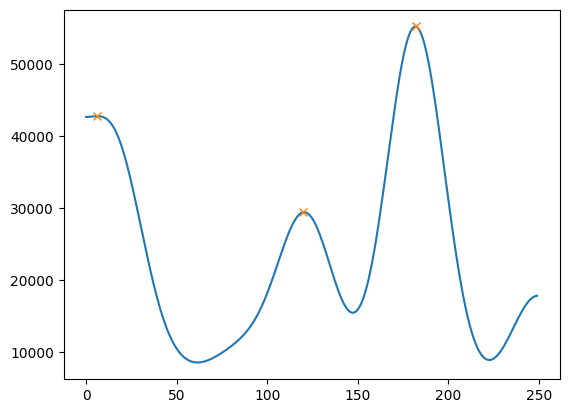

6 182


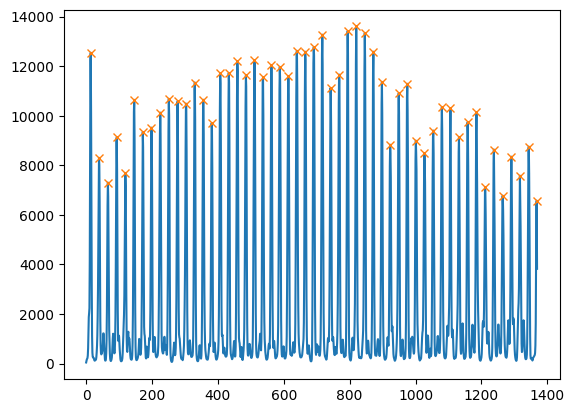

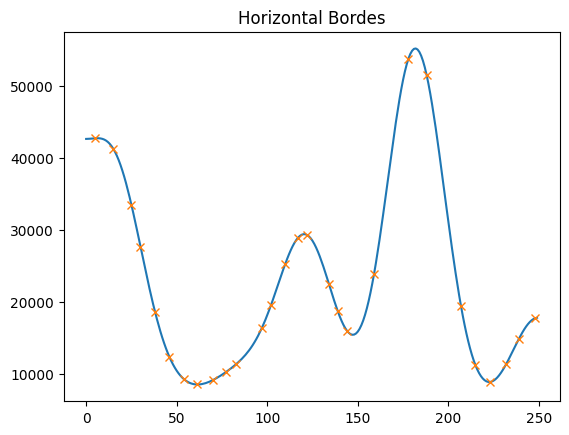

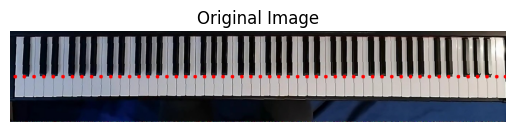

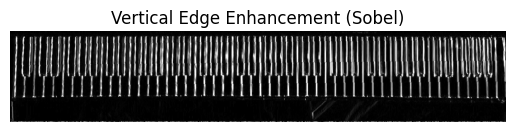

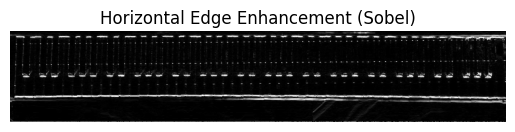

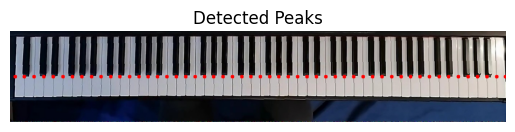

53
[  14   39   66   93  119  146  172  198  225  251  278  303  330  356
  381  407  433  459  485  511  537  562  588  614  640  665  691  717
  742  768  794  820  846  872  898  923  949  975 1001 1027 1054 1080
 1106 1132 1158 1185 1211 1238 1265 1291 1317 1344 1368]
[(14, 39), (39, 66), (66, 93), (93, 119), (119, 146), (146, 172), (172, 198), (198, 225), (225, 251), (251, 278), (278, 303), (303, 330), (330, 356), (356, 381), (381, 407), (407, 433), (433, 459), (459, 485), (485, 511), (511, 537), (537, 562), (562, 588), (588, 614), (614, 640), (640, 665), (665, 691), (691, 717), (717, 742), (742, 768), (768, 794), (794, 820), (820, 846), (846, 872), (872, 898), (898, 923), (923, 949), (949, 975), (975, 1001), (1001, 1027), (1027, 1054), (1054, 1080), (1080, 1106), (1106, 1132), (1132, 1158), (1158, 1185), (1185, 1211), (1211, 1238), (1238, 1265), (1265, 1291), (1291, 1317), (1317, 1344), (1344, 1368)]


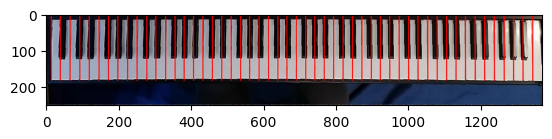

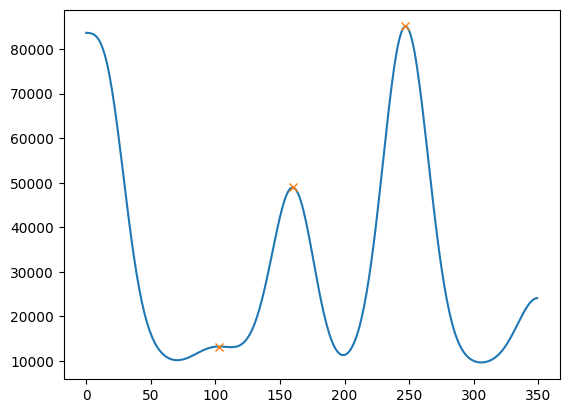

103 247


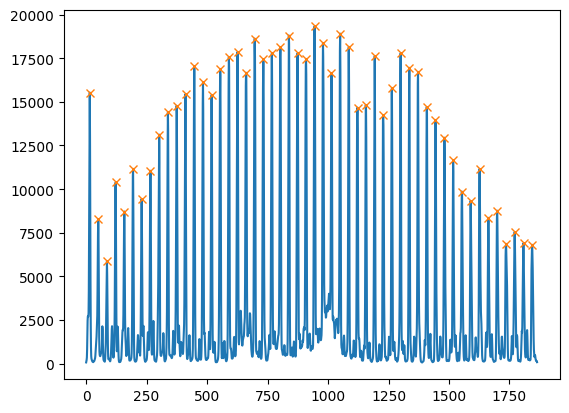

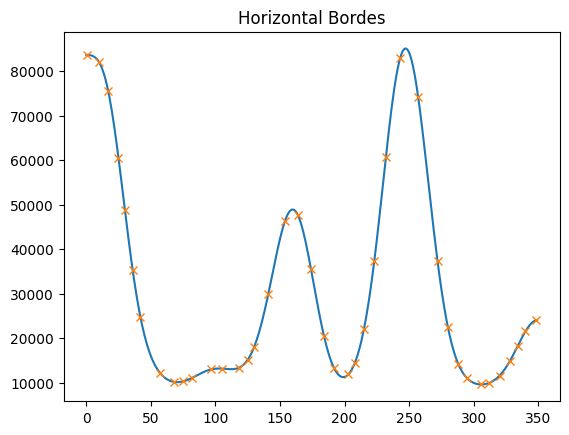

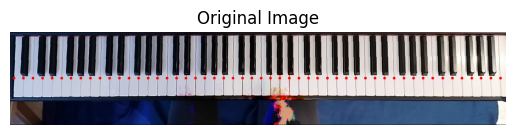

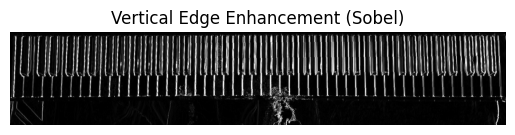

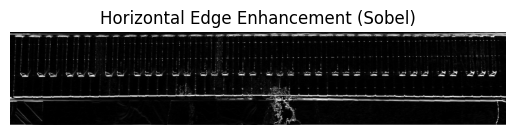

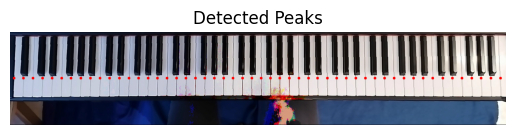

52
[  15   50   86  122  158  194  229  266  302  338  374  411  447  483
  519  554  590  626  661  697  732  768  803  838  874  909  944  979
 1014 1050 1086 1122 1156 1193 1228 1264 1300 1336 1372 1408 1444 1481
 1517 1553 1589 1627 1663 1699 1736 1771 1808 1844]
[(15, 50), (50, 86), (86, 122), (122, 158), (158, 194), (194, 229), (229, 266), (266, 302), (302, 338), (338, 374), (374, 411), (411, 447), (447, 483), (483, 519), (519, 554), (554, 590), (590, 626), (626, 661), (661, 697), (697, 732), (732, 768), (768, 803), (803, 838), (838, 874), (874, 909), (909, 944), (944, 979), (979, 1014), (1014, 1050), (1050, 1086), (1086, 1122), (1122, 1156), (1156, 1193), (1193, 1228), (1228, 1264), (1264, 1300), (1300, 1336), (1336, 1372), (1372, 1408), (1408, 1444), (1444, 1481), (1481, 1517), (1517, 1553), (1553, 1589), (1589, 1627), (1627, 1663), (1663, 1699), (1699, 1736), (1736, 1771), (1771, 1808), (1808, 1844)]


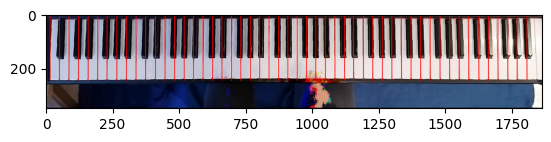

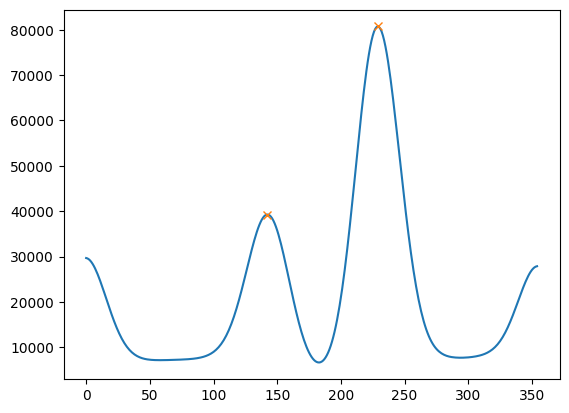

142 229


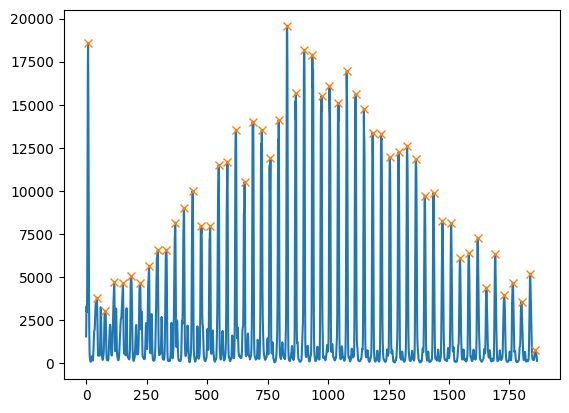

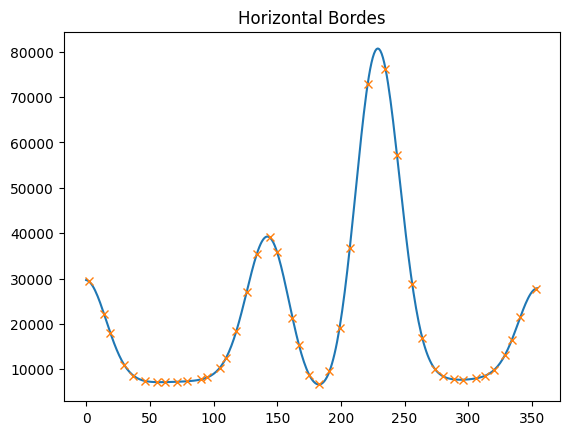

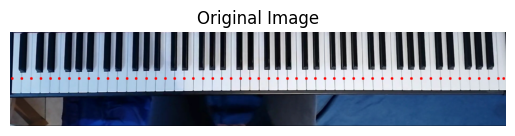

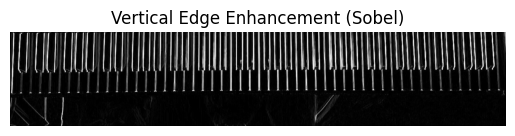

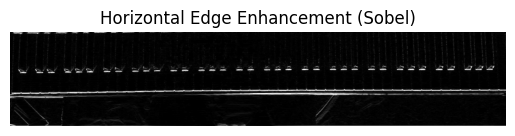

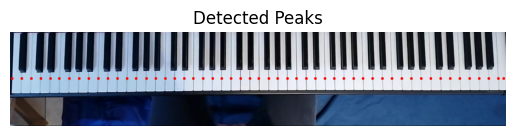

53
[   8   44   80  116  152  185  223  260  296  332  368  404  440  474
  513  548  584  619  655  689  726  762  796  831  867  902  935  973
 1006 1043 1077 1114 1148 1184 1219 1255 1292 1327 1363 1400 1436 1473
 1509 1546 1582 1619 1655 1691 1728 1764 1800 1836 1856]
[(8, 44), (44, 80), (80, 116), (116, 152), (152, 185), (185, 223), (223, 260), (260, 296), (296, 332), (332, 368), (368, 404), (404, 440), (440, 474), (474, 513), (513, 548), (548, 584), (584, 619), (619, 655), (655, 689), (689, 726), (726, 762), (762, 796), (796, 831), (831, 867), (867, 902), (902, 935), (935, 973), (973, 1006), (1006, 1043), (1043, 1077), (1077, 1114), (1114, 1148), (1148, 1184), (1184, 1219), (1219, 1255), (1255, 1292), (1292, 1327), (1327, 1363), (1363, 1400), (1400, 1436), (1436, 1473), (1473, 1509), (1509, 1546), (1546, 1582), (1582, 1619), (1619, 1655), (1655, 1691), (1691, 1728), (1728, 1764), (1764, 1800), (1800, 1836), (1836, 1856)]


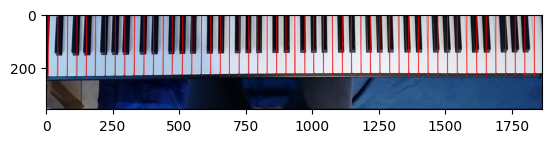

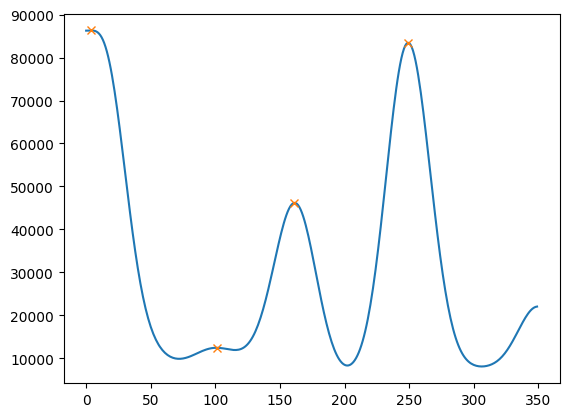

4 249


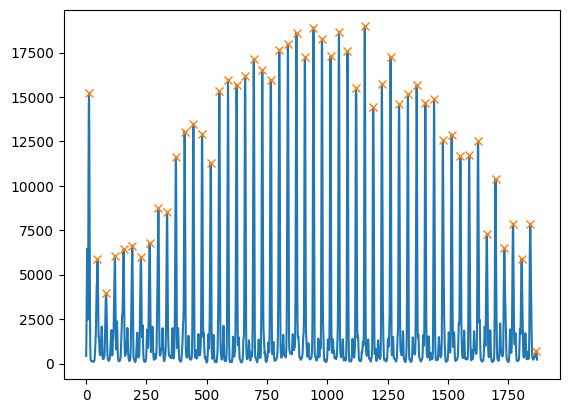

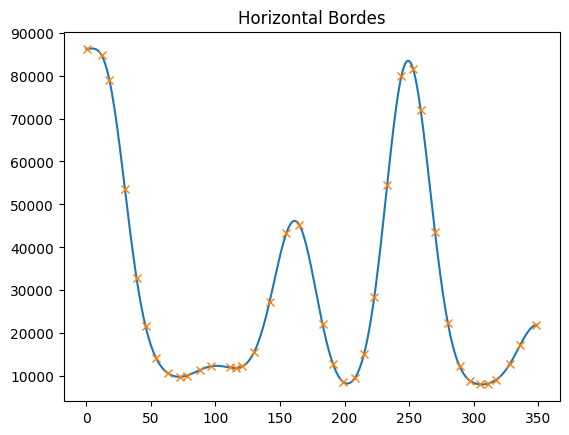

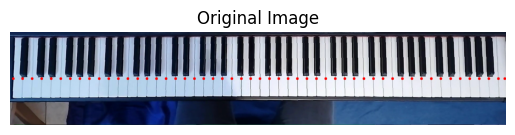

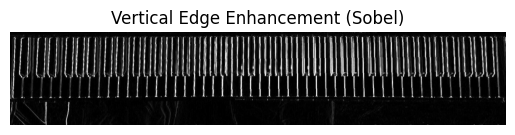

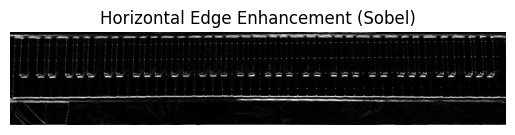

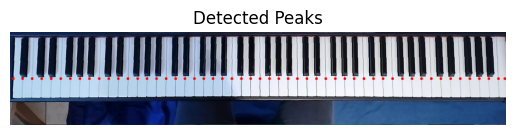

53
[  12   47   83  119  155  191  227  263  299  336  372  408  444  481
  516  552  588  624  659  695  730  765  800  836  872  907  942  978
 1013 1048 1083 1119 1155 1190 1226 1262 1297 1334 1370 1406 1442 1479
 1515 1551 1588 1624 1661 1697 1733 1769 1805 1841 1865]
[(12, 47), (47, 83), (83, 119), (119, 155), (155, 191), (191, 227), (227, 263), (263, 299), (299, 336), (336, 372), (372, 408), (408, 444), (444, 481), (481, 516), (516, 552), (552, 588), (588, 624), (624, 659), (659, 695), (695, 730), (730, 765), (765, 800), (800, 836), (836, 872), (872, 907), (907, 942), (942, 978), (978, 1013), (1013, 1048), (1048, 1083), (1083, 1119), (1119, 1155), (1155, 1190), (1190, 1226), (1226, 1262), (1262, 1297), (1297, 1334), (1334, 1370), (1370, 1406), (1406, 1442), (1442, 1479), (1479, 1515), (1515, 1551), (1551, 1588), (1588, 1624), (1624, 1661), (1661, 1697), (1697, 1733), (1733, 1769), (1769, 1805), (1805, 1841), (1841, 1865)]


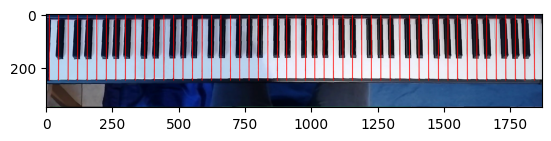

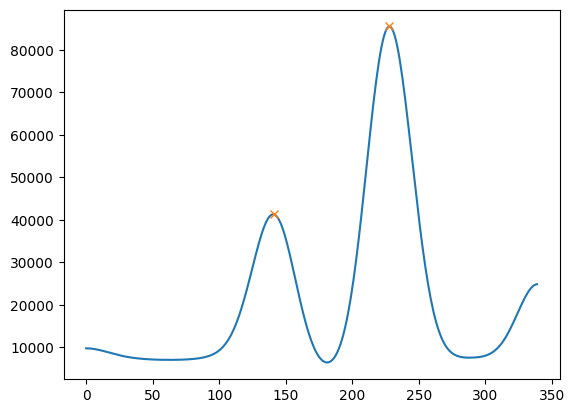

141 228


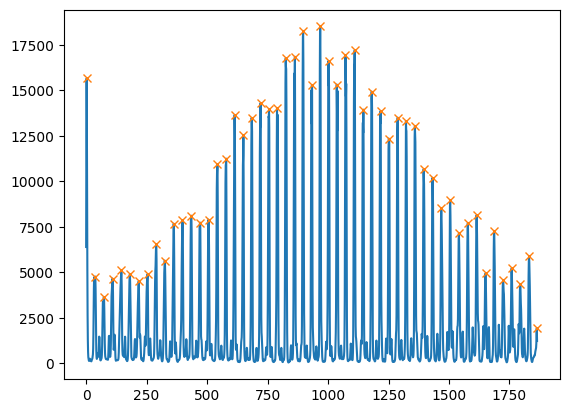

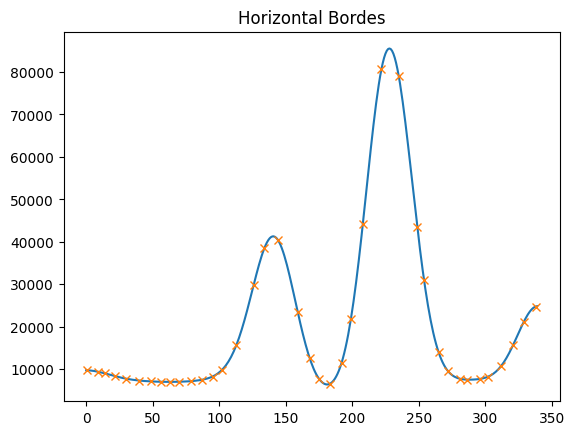

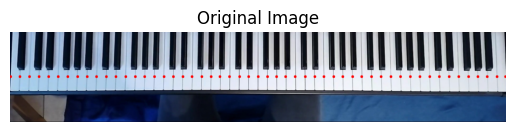

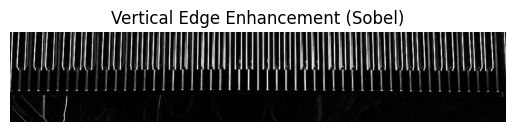

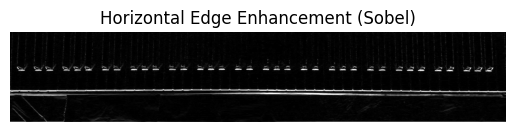

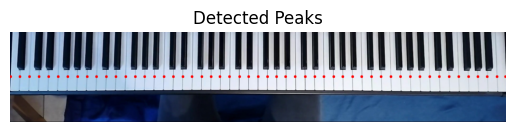

53
[   2   37   73  109  145  181  217  254  290  325  362  398  435  471
  506  543  579  614  650  684  721  756  789  825  863  897  933  968
 1002 1036 1072 1110 1146 1180 1217 1251 1288 1322 1359 1395 1432 1468
 1505 1541 1578 1614 1651 1687 1724 1759 1794 1831 1863]
[(2, 37), (37, 73), (73, 109), (109, 145), (145, 181), (181, 217), (217, 254), (254, 290), (290, 325), (325, 362), (362, 398), (398, 435), (435, 471), (471, 506), (506, 543), (543, 579), (579, 614), (614, 650), (650, 684), (684, 721), (721, 756), (756, 789), (789, 825), (825, 863), (863, 897), (897, 933), (933, 968), (968, 1002), (1002, 1036), (1036, 1072), (1072, 1110), (1110, 1146), (1146, 1180), (1180, 1217), (1217, 1251), (1251, 1288), (1288, 1322), (1322, 1359), (1359, 1395), (1395, 1432), (1432, 1468), (1468, 1505), (1505, 1541), (1541, 1578), (1578, 1614), (1614, 1651), (1651, 1687), (1687, 1724), (1724, 1759), (1759, 1794), (1794, 1831), (1831, 1863)]


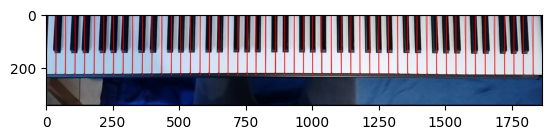

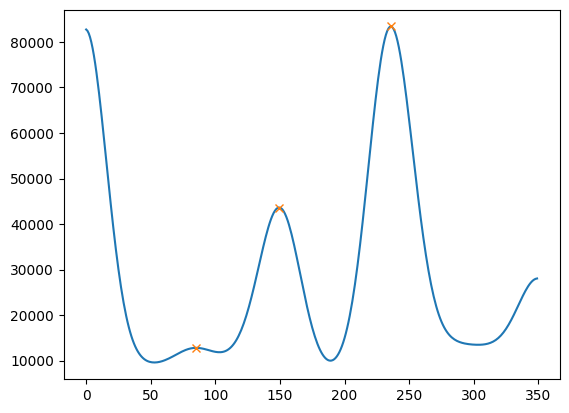

85 236


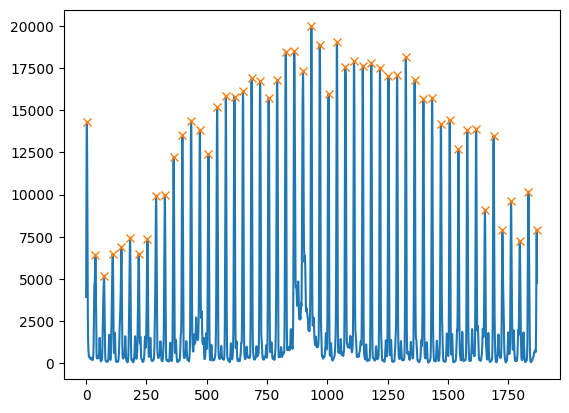

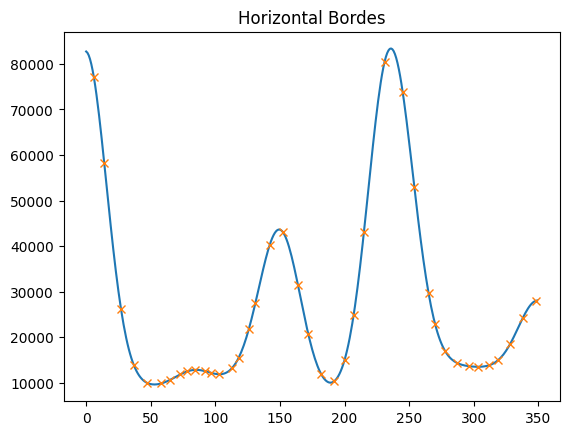

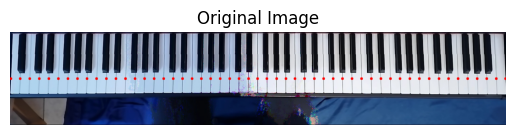

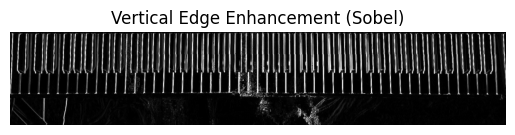

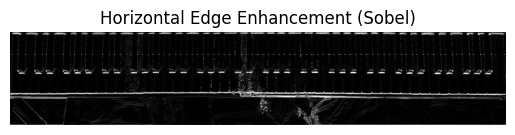

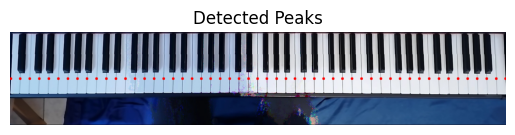

53
[   3   38   74  110  146  182  218  254  290  326  363  399  435  471
  507  543  579  615  650  686  721  756  792  828  863  899  933  968
 1005 1040 1074 1110 1147 1182 1218 1253 1289 1325 1362 1398 1434 1470
 1507 1543 1580 1617 1653 1689 1725 1761 1797 1833 1868]
[(3, 38), (38, 74), (74, 110), (110, 146), (146, 182), (182, 218), (218, 254), (254, 290), (290, 326), (326, 363), (363, 399), (399, 435), (435, 471), (471, 507), (507, 543), (543, 579), (579, 615), (615, 650), (650, 686), (686, 721), (721, 756), (756, 792), (792, 828), (828, 863), (863, 899), (899, 933), (933, 968), (968, 1005), (1005, 1040), (1040, 1074), (1074, 1110), (1110, 1147), (1147, 1182), (1182, 1218), (1218, 1253), (1253, 1289), (1289, 1325), (1325, 1362), (1362, 1398), (1398, 1434), (1434, 1470), (1470, 1507), (1507, 1543), (1543, 1580), (1580, 1617), (1617, 1653), (1653, 1689), (1689, 1725), (1725, 1761), (1761, 1797), (1797, 1833), (1833, 1868)]


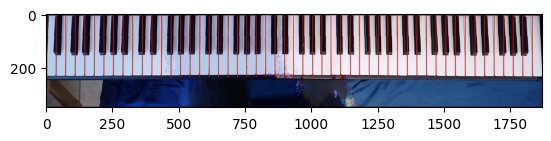

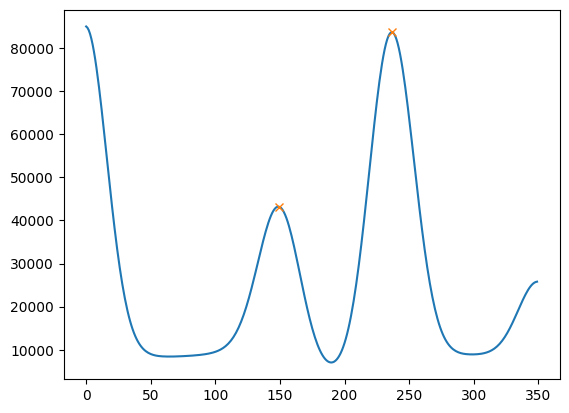

149 237


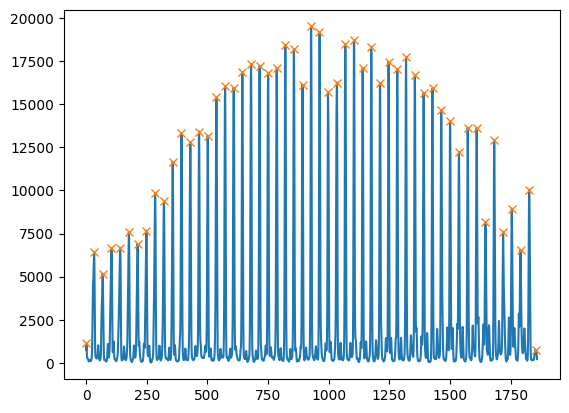

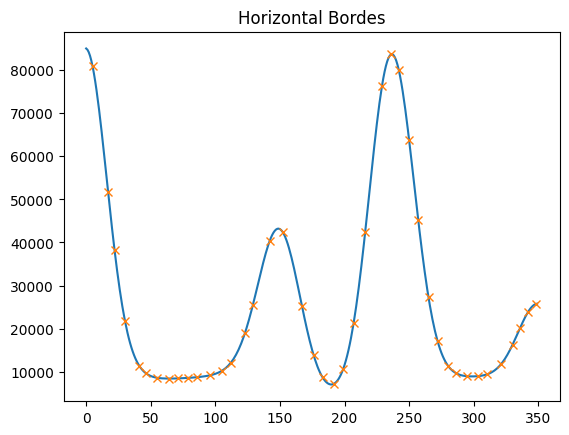

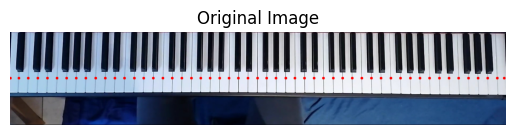

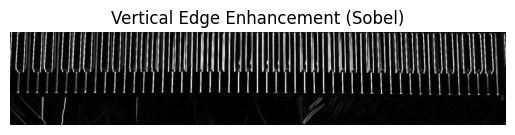

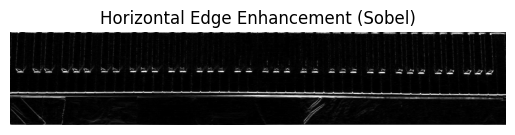

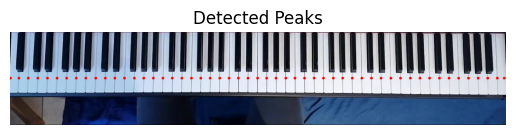

53
[   1   33   68  104  140  176  212  248  284  321  357  393  429  466
  501  537  573  608  644  680  715  750  786  821  856  892  928  962
  997 1034 1068 1104 1140 1175 1212 1247 1283 1319 1355 1391 1428 1464
 1501 1537 1573 1610 1646 1682 1719 1755 1791 1827 1853]
[(1, 33), (33, 68), (68, 104), (104, 140), (140, 176), (176, 212), (212, 248), (248, 284), (284, 321), (321, 357), (357, 393), (393, 429), (429, 466), (466, 501), (501, 537), (537, 573), (573, 608), (608, 644), (644, 680), (680, 715), (715, 750), (750, 786), (786, 821), (821, 856), (856, 892), (892, 928), (928, 962), (962, 997), (997, 1034), (1034, 1068), (1068, 1104), (1104, 1140), (1140, 1175), (1175, 1212), (1212, 1247), (1247, 1283), (1283, 1319), (1319, 1355), (1355, 1391), (1391, 1428), (1428, 1464), (1464, 1501), (1501, 1537), (1537, 1573), (1573, 1610), (1610, 1646), (1646, 1682), (1682, 1719), (1719, 1755), (1755, 1791), (1791, 1827), (1827, 1853)]


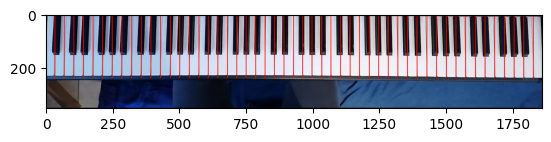

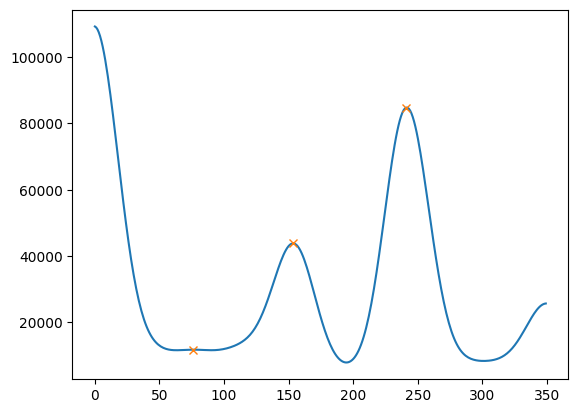

76 241


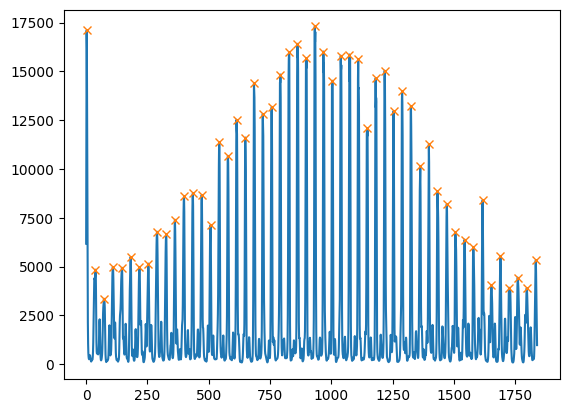

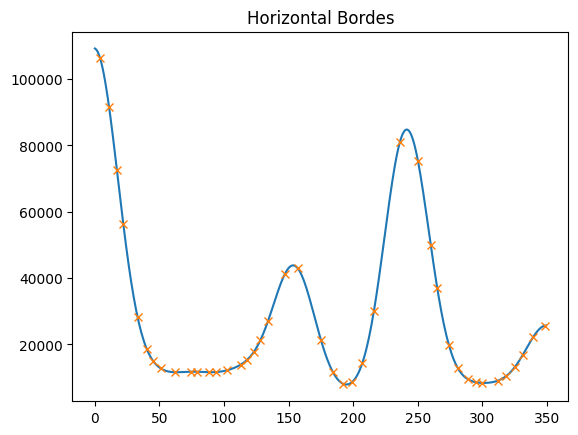

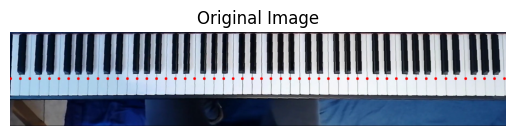

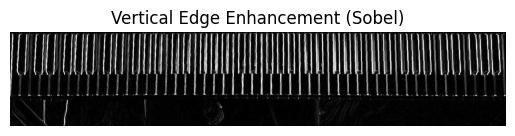

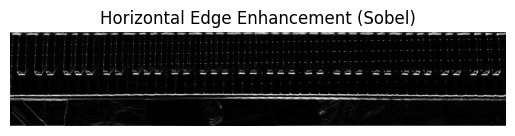

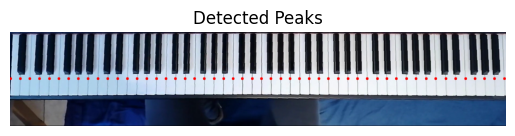

52
[   2   38   73  109  146  181  217  253  289  326  362  399  435  471
  507  543  578  613  649  684  720  757  792  827  861  898  932  967
 1004 1038 1073 1109 1145 1180 1217 1253 1288 1324 1362 1397 1432 1470
 1505 1543 1578 1616 1652 1689 1724 1759 1796 1833]
[(2, 38), (38, 73), (73, 109), (109, 146), (146, 181), (181, 217), (217, 253), (253, 289), (289, 326), (326, 362), (362, 399), (399, 435), (435, 471), (471, 507), (507, 543), (543, 578), (578, 613), (613, 649), (649, 684), (684, 720), (720, 757), (757, 792), (792, 827), (827, 861), (861, 898), (898, 932), (932, 967), (967, 1004), (1004, 1038), (1038, 1073), (1073, 1109), (1109, 1145), (1145, 1180), (1180, 1217), (1217, 1253), (1253, 1288), (1288, 1324), (1324, 1362), (1362, 1397), (1397, 1432), (1432, 1470), (1470, 1505), (1505, 1543), (1543, 1578), (1578, 1616), (1616, 1652), (1652, 1689), (1689, 1724), (1724, 1759), (1759, 1796), (1796, 1833)]


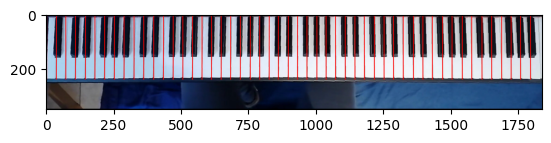

In [265]:
import pandas as pd
import json

for i in [5, 10, 21, 23, 24, 25, 26, 27]:
    path = f'dataset/MIDItest/miditest_videos/no_hand_frames/{i}/im.jpg'
    top_border, bottom_border, white_keys, processing_log = process_image(path)
    plot_processing_log(processing_log)
    print(len(white_keys))
    print(white_keys)
    white_keys_locations = [(int(i),int(j)) for i, j in zip(white_keys, white_keys[1:])]
    print(white_keys_locations)
    # Draw lines at the top and bottom borders
    im_rgb = cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    for white_key in white_keys_locations:
        cv2.line(im_rgb, (white_key[0], top_border), (white_key[0], bottom_border), (255, 0, 0), 2)
    # plt.imshow(im_rgb[top_border:bottom_border, white_keys[0]:white_keys[1]], cmap='gray')
    plt.imshow(im_rgb)
    plt.show()

    border_information = {
        "top_border": int(top_border),
        "bottom_border": int(bottom_border),
        "white_keys": white_keys.tolist(),
        "white_keys_locations": white_keys_locations
    }

    output_path = f'dataset/MIDItest/miditest_videos/borders/{i}.json'
    with open(output_path, 'w') as json_file:
        json.dump(border_information, json_file)
